In [1]:
import geopandas as gpd
import numpy as np
import shapely
import geofileops as gfo
import tempfile
from pathlib import Path
import matplotlib.pyplot as plt
import logging

from scientific_python_utils.geometric import merge_classified_polygons

In [2]:
N_SQUARES = 40
SQUARE_WIDTH = 0.1
N_CLASSES = 4

Create dummy data

<Axes: >

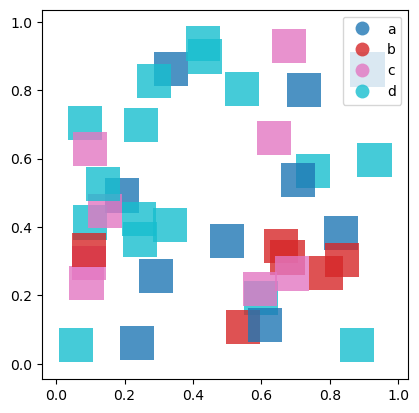

In [3]:
tl_corners = np.random.random((N_SQUARES, 2)) * (1 - SQUARE_WIDTH)
boxes = [shapely.box(tl[0], tl[1], tl[0] + SQUARE_WIDTH, tl[1] + SQUARE_WIDTH) for tl in tl_corners]
classes = np.random.randint(0, N_CLASSES, size=N_SQUARES)
classes = np.array(["abcd"[i] for i in classes])

classified_polygons = gpd.GeoDataFrame({"geometry": boxes, "classes": classes}, crs=3311)
classified_polygons.plot("classes",alpha=0.8, cmap="tab10", legend=True)

/home/exouser/miniconda3/envs/spatial-utils/lib/python3.10/site-packages/geopandas/geodataframe.py:1819: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


Ties had to be broken for 13.9% of the total predictions


,max_class,geometry
0,d,"MULTIPOLYGON (((0.107 0.104, 0.107 0.004, 0.00..."
1,a,"MULTIPOLYGON (((0.286 0.011, 0.186 0.011, 0.18..."
2,c,"MULTIPOLYGON (((0.047 0.282, 0.047 0.287, 0.13..."
3,b,"MULTIPOLYGON (((0.048 0.382, 0.147 0.382, 0.14..."


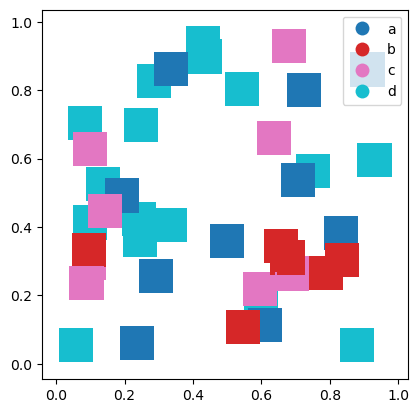

In [4]:
merged = merge_classified_polygons(classified_polygons=classified_polygons, class_column="classes", print_tiebreaking_stats=True)
merged.plot("max_class", cmap="tab10", legend=True)
merged